In [1]:
!pip install -U /kaggle/input/faiss-gpu-173-python310/faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!cp -rf /kaggle/input/sentence-transformers-222/sentence-transformers /kaggle/working/sentence-transformers
!pip install -U /kaggle/working/sentence-transformers
!pip install -U /kaggle/input/blingfire-018/blingfire-0.1.8-py3-none-any.whl

!pip install --no-index --no-deps /kaggle/input/llm-whls/transformers-4.31.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/peft-0.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/datasets-2.14.3-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/trl-0.5.0-py3-none-any.whl

Processing /kaggle/input/faiss-gpu-173-python310/faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./sentence-transformers
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=126134 sha256=3eecc93447adc585c7705d7cca3c5e85be4a01eeafd2d531b608b01db0083736
  Stored in directory: /root/.cache/pip/wheels/6c/ea/76/d9a930b223b1d3d5d6aff69458725316b0fe205b854faf1812
Successfully built sentence-transformers
Processing /kaggle/input/blingfire-018/blingfire-0.1.8-py3-none-any.whl
Processing /kaggle/input/llm-whls/transformers-4.31.0-py3-none-any.whl
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2
Processing /kaggle/input/llm-whls/peft-0.4.0-py3-none-any.whl
Processing /kaggle/input/llm-whls/datasets-2.14.3-py3-none-any.whl
  Attempting uninsta

In [2]:
import os
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf
from __future__ import annotations
from collections.abc import Iterable
import faiss
from faiss import write_index, read_index
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

import torch
import ctypes

libc = ctypes.CDLL("libc.so.6")
from dataclasses import dataclass
from typing import Optional, Union
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import (
    PreTrainedTokenizerBase,
    PaddingStrategy,
)
from torch.utils.data import DataLoader
import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
df_train = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/train.csv")
df_test = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv")
df_samp = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/sample_submission.csv")
df_extra = pd.read_csv("/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv")
df_extra_RO = pd.read_csv("/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv")

In [4]:
# 我们有两个名为df_train和df_extra的数据框，行数相同
# 将它们连接在一起
concatenated_df = pd.concat([df_train])
df_train.reset_index(inplace=True, drop=True)
df_train.shape

(200, 8)

In [5]:
import random
import pandas as pd
from transformers import pipeline, AutoTokenizer

# 加载BERT分词器
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/bert-base-uncased")

# 初始化使用BERT进行遮蔽语言建模的管道
mlm_fill_mask = pipeline(task="fill-mask", model="/kaggle/input/bert-base-uncased")


# 定义使用不同技术进行数据增强的函数
def augment_data(original_df, num_augmented_rows):
    augmented_data = []
    original_rows = original_df.shape[0]

    # 上下文词嵌入增强的函数
    def contextual_embeddings(text):
        # 对文本进行标记化处理
        tokenized_text = tokenizer(text, return_tensors="pt")

        # 找到标记化文本中的遮蔽位置
        masked_positions = [
            i for i, token in enumerate(tokenized_text["input_ids"][0]) if token == tokenizer.mask_token_id
        ]

        # 如果找不到遮蔽位置，则返回原始文本
        if not masked_positions:
            return text

        # 随机选择一个遮蔽位置
        random_masked_position = random.choice(masked_positions)

        # 使用遮蔽语言建模预测遮蔽词
        masked_text = text.replace("[MASK]", tokenizer.mask_token)
        predicted_word = mlm_fill_mask(masked_text)[0]["token_str"]

        # 在文本中用预测的词替换遮蔽词
        augmented_text = text.replace(tokenizer.mask_token, predicted_word, 1)

        return augmented_text

    # 同义词替换增强的函数
    def augment_with_synonyms(text):
        # 您可以在此处使用自己的同义词替换逻辑
        # 为简单起见，假设我们有一个预定义的同义词词典
        synonym_dict = {
            "good": ["excellent", "great", "superb", "fine"],
            "bad": ["poor", "terrible", "awful", "horrible"],
            # 根据需要添加更多同义词
        }

        words = text.split()
        augmented_words = [
            (synonym_dict[word][random.randint(0, len(synonym_dict[word]) - 1)] if word in synonym_dict else word)
            for word in words
        ]
        return " ".join(augmented_words)

    for _ in range(num_augmented_rows):
        original_row = original_df.iloc[random.randint(0, original_rows - 1)]
        augmented_row = original_row.copy()

        # 对"prompt"应用增强技术
        augmented_row["prompt"] = contextual_embeddings(original_row["prompt"])

        # 对答案选项（A、B、C、D、E）应用同义词替换
        for choice in ["A", "B", "C", "D", "E"]:
            augmented_row[choice] = augment_with_synonyms(original_row[choice])

        augmented_data.append(augmented_row)

    return augmented_data


# 假设您有一个包含列："prompt"、"A"、"B"、"C"、"D"、"E" 和 "answer" 的 concatenated_df 数据框
# 设置所需的行数
desired_rows = 500

# 计算需要达到所需总行数的行数
additional_rows = desired_rows - concatenated_df.shape[0]

# 增强数据
augmented_data = augment_data(concatenated_df, additional_rows)

# 将增强的数据转换为数据框
augmented_df = pd.DataFrame(augmented_data)

# 将原始数据框与增强的数据框连接以获得最终的包含3000行的数据框
final_df = pd.concat([concatenated_df, augmented_df], ignore_index=True)

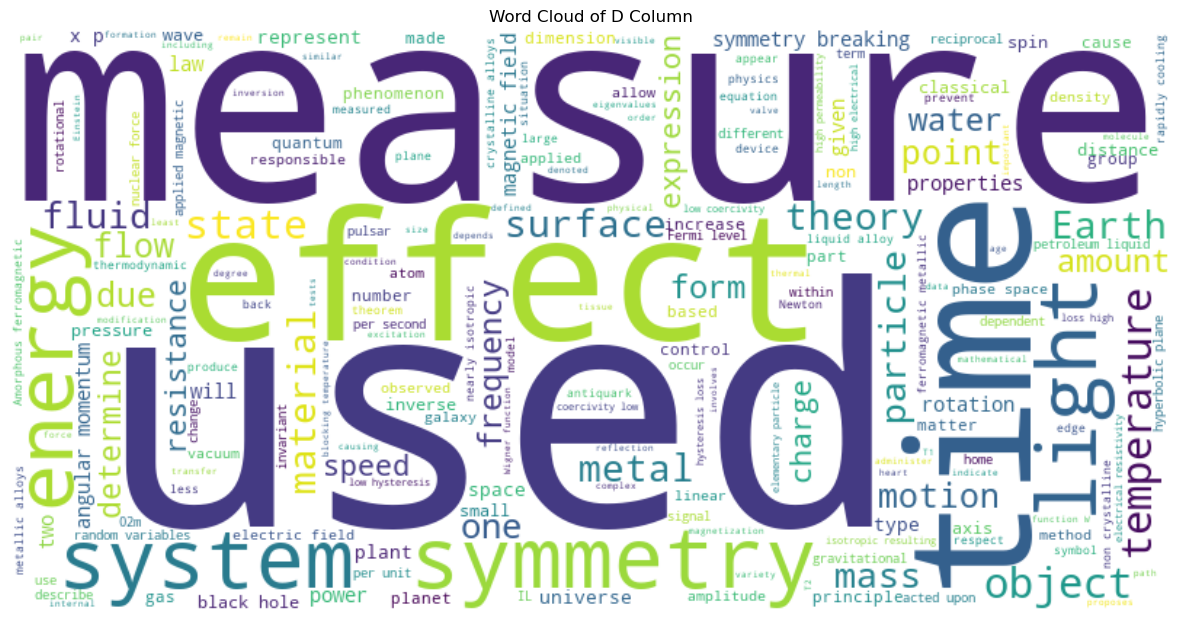

In [6]:
from wordcloud import WordCloud

# Concatenate the sentences into a single string
text_data = " ".join(final_df["D"])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of D Column")
plt.show()

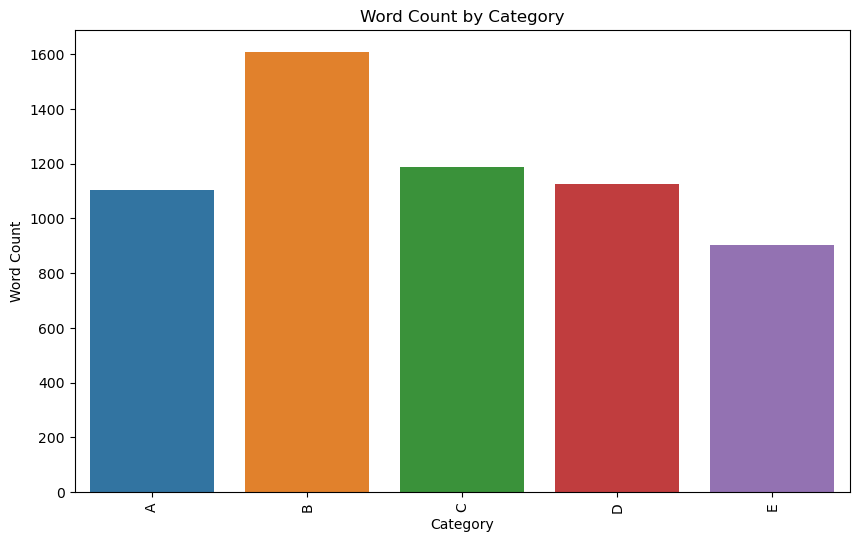

In [7]:
import seaborn as sns

# Calculate the word count by category
category_word_count = final_df.groupby("answer")["prompt"].apply(lambda x: " ".join(x)).str.split().apply(len)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=category_word_count.index, y=category_word_count.values)
plt.xlabel("Category")
plt.ylabel("Word Count")
plt.title("Word Count by Category")
plt.xticks(rotation=90)
plt.show()

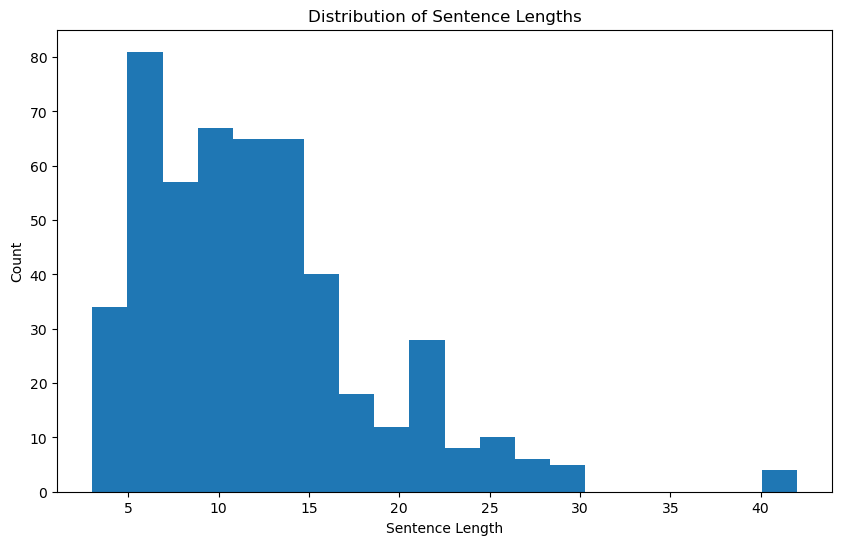

In [8]:
# Calculate the lengths of each sentence
sentence_lengths = final_df["prompt"].str.split().apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=20)
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.title("Distribution of Sentence Lengths")
plt.show()

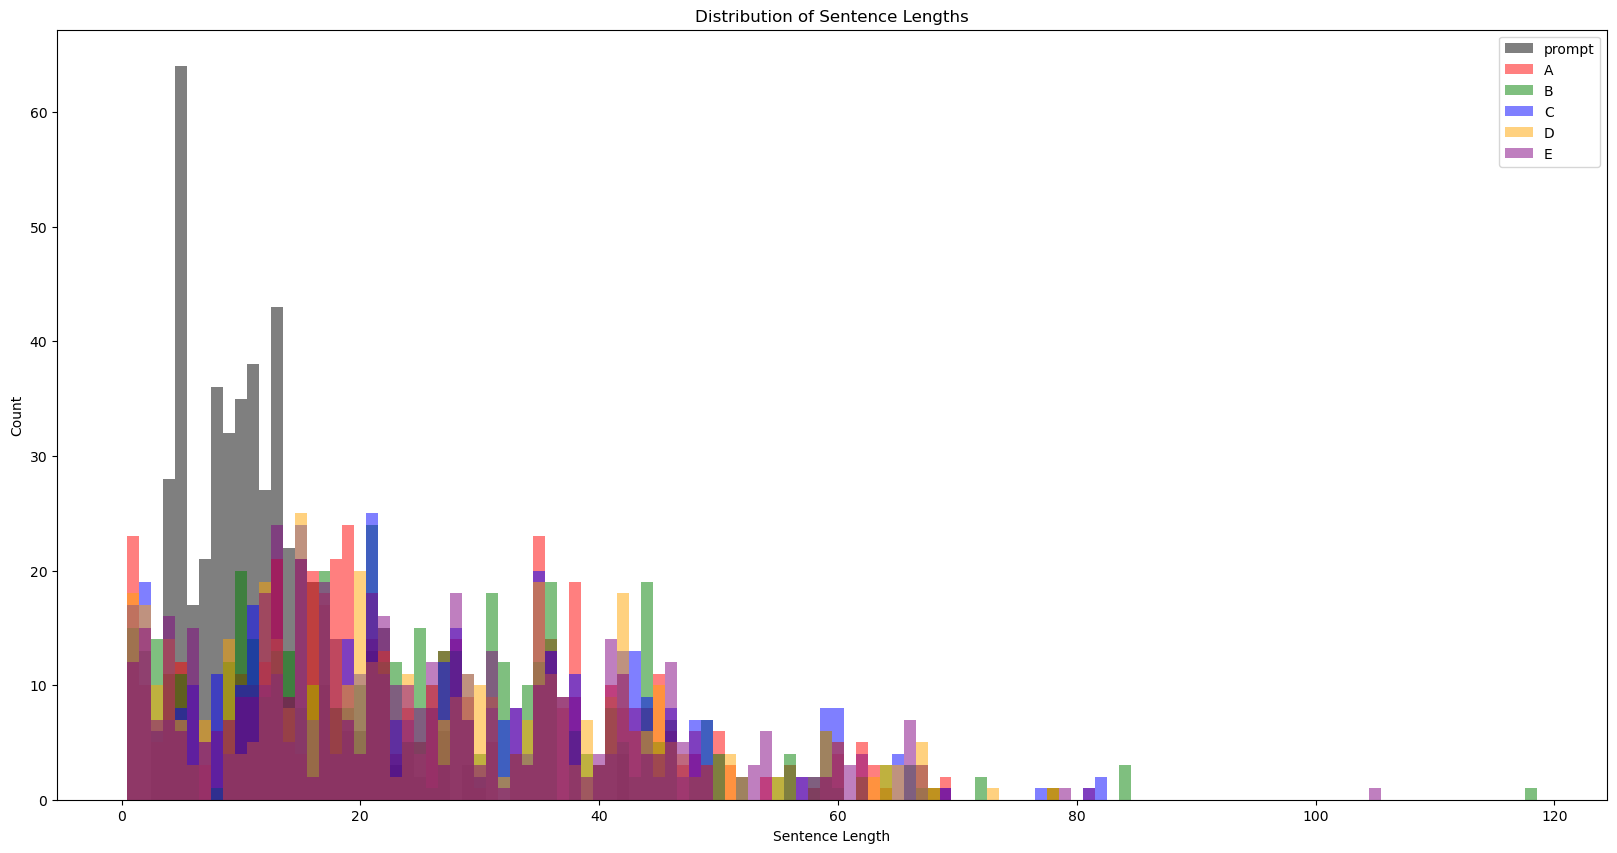

In [9]:
# Calculate the lengths of each sentence for columns A, B, C, D, E
columns = ["prompt", "A", "B", "C", "D", "E"]
sentence_lengths = {}
for col in columns:
    sentence_lengths[col] = final_df[col].str.split().apply(len)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# Set up color palette
colors = ["black", "red", "green", "blue", "orange", "purple"]

# Plot the histograms side by side
for i, col in enumerate(columns):
    bins = np.arange(min(sentence_lengths[col]), max(sentence_lengths[col]) + 2) - 0.5
    ax.hist(sentence_lengths[col], bins=bins, color=colors[i], alpha=0.5, label=col)

# Customize the plot
ax.set_xlabel("Sentence Length")
ax.set_ylabel("Count")
ax.set_title("Distribution of Sentence Lengths")
ax.legend()

# Show the plot
plt.show()

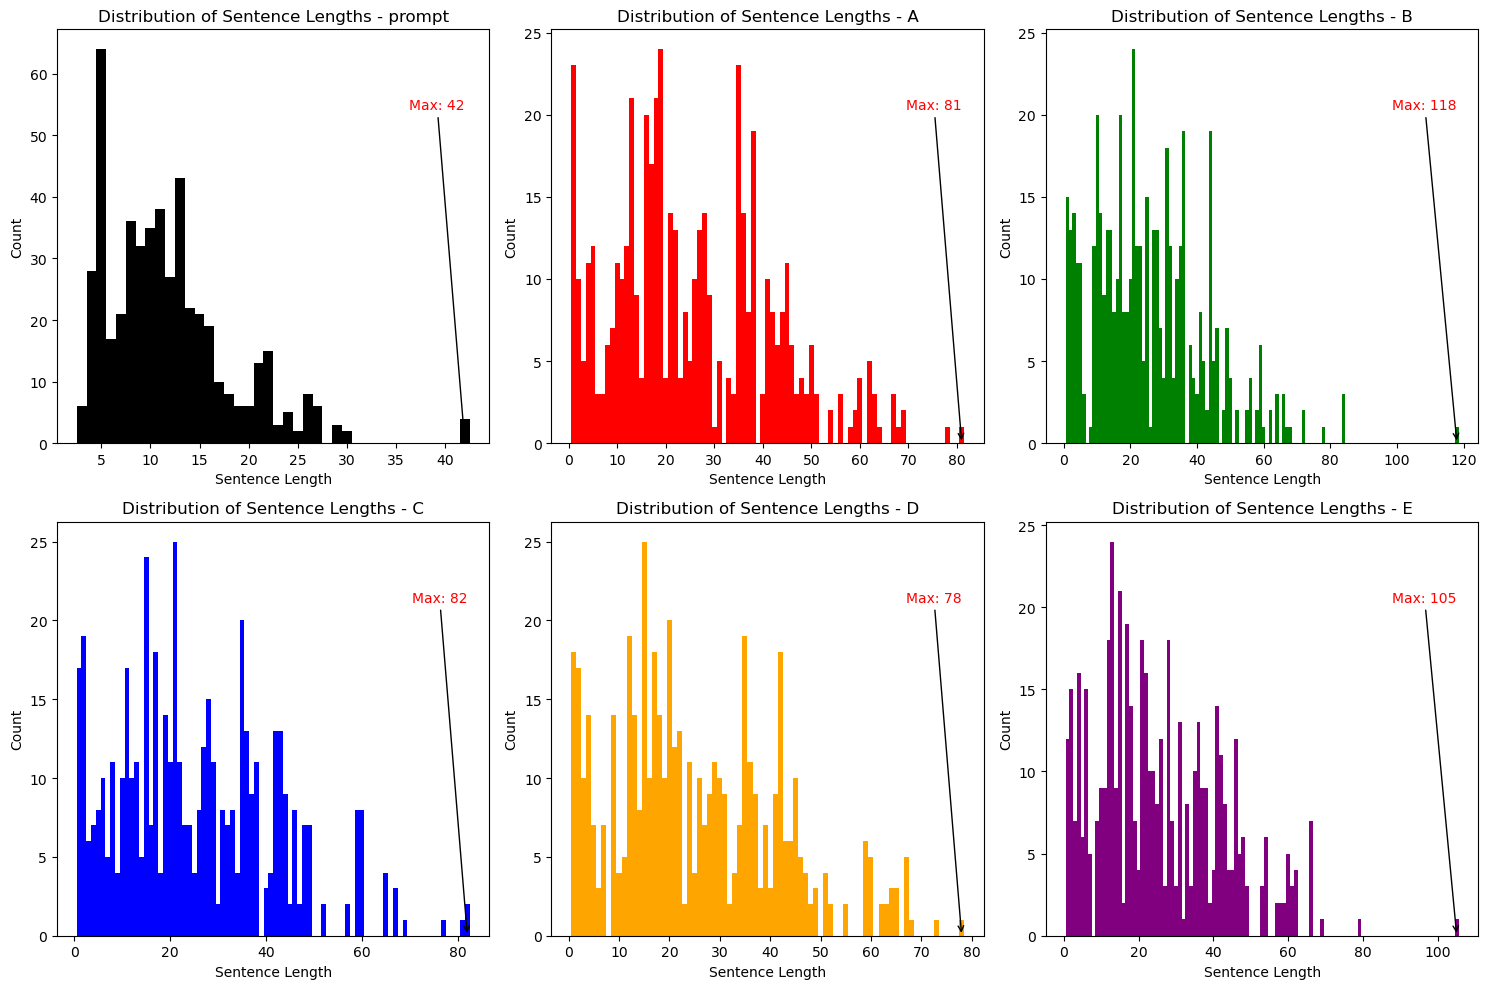

In [10]:
# Calculate the lengths of each sentence for columns A, B, C, D, E
columns = ["prompt", "A", "B", "C", "D", "E"]
colors = ["black", "red", "green", "blue", "orange", "purple"]

# Set up the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot the histograms for each column with different colors and annotate the maximum value
for i, col in enumerate(columns):
    bins = (
        np.arange(
            min(final_df[col].str.split().apply(len)),
            max(final_df[col].str.split().apply(len)) + 2,
        )
        - 0.5
    )
    axes[i].hist(final_df[col].str.split().apply(len), bins=bins, color=colors[i])
    axes[i].set_xlabel("Sentence Length")
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"Distribution of Sentence Lengths - {col}")
    max_length = final_df[col].str.split().apply(len).max()
    axes[i].annotate(
        f"Max: {max_length}",
        xy=(max_length, 0),
        xytext=(max_length, 0.8 * axes[i].get_ylim()[1]),
        color="red",
        ha="right",
        va="bottom",
        arrowprops=dict(arrowstyle="->"),
    )

# Remove any unused subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

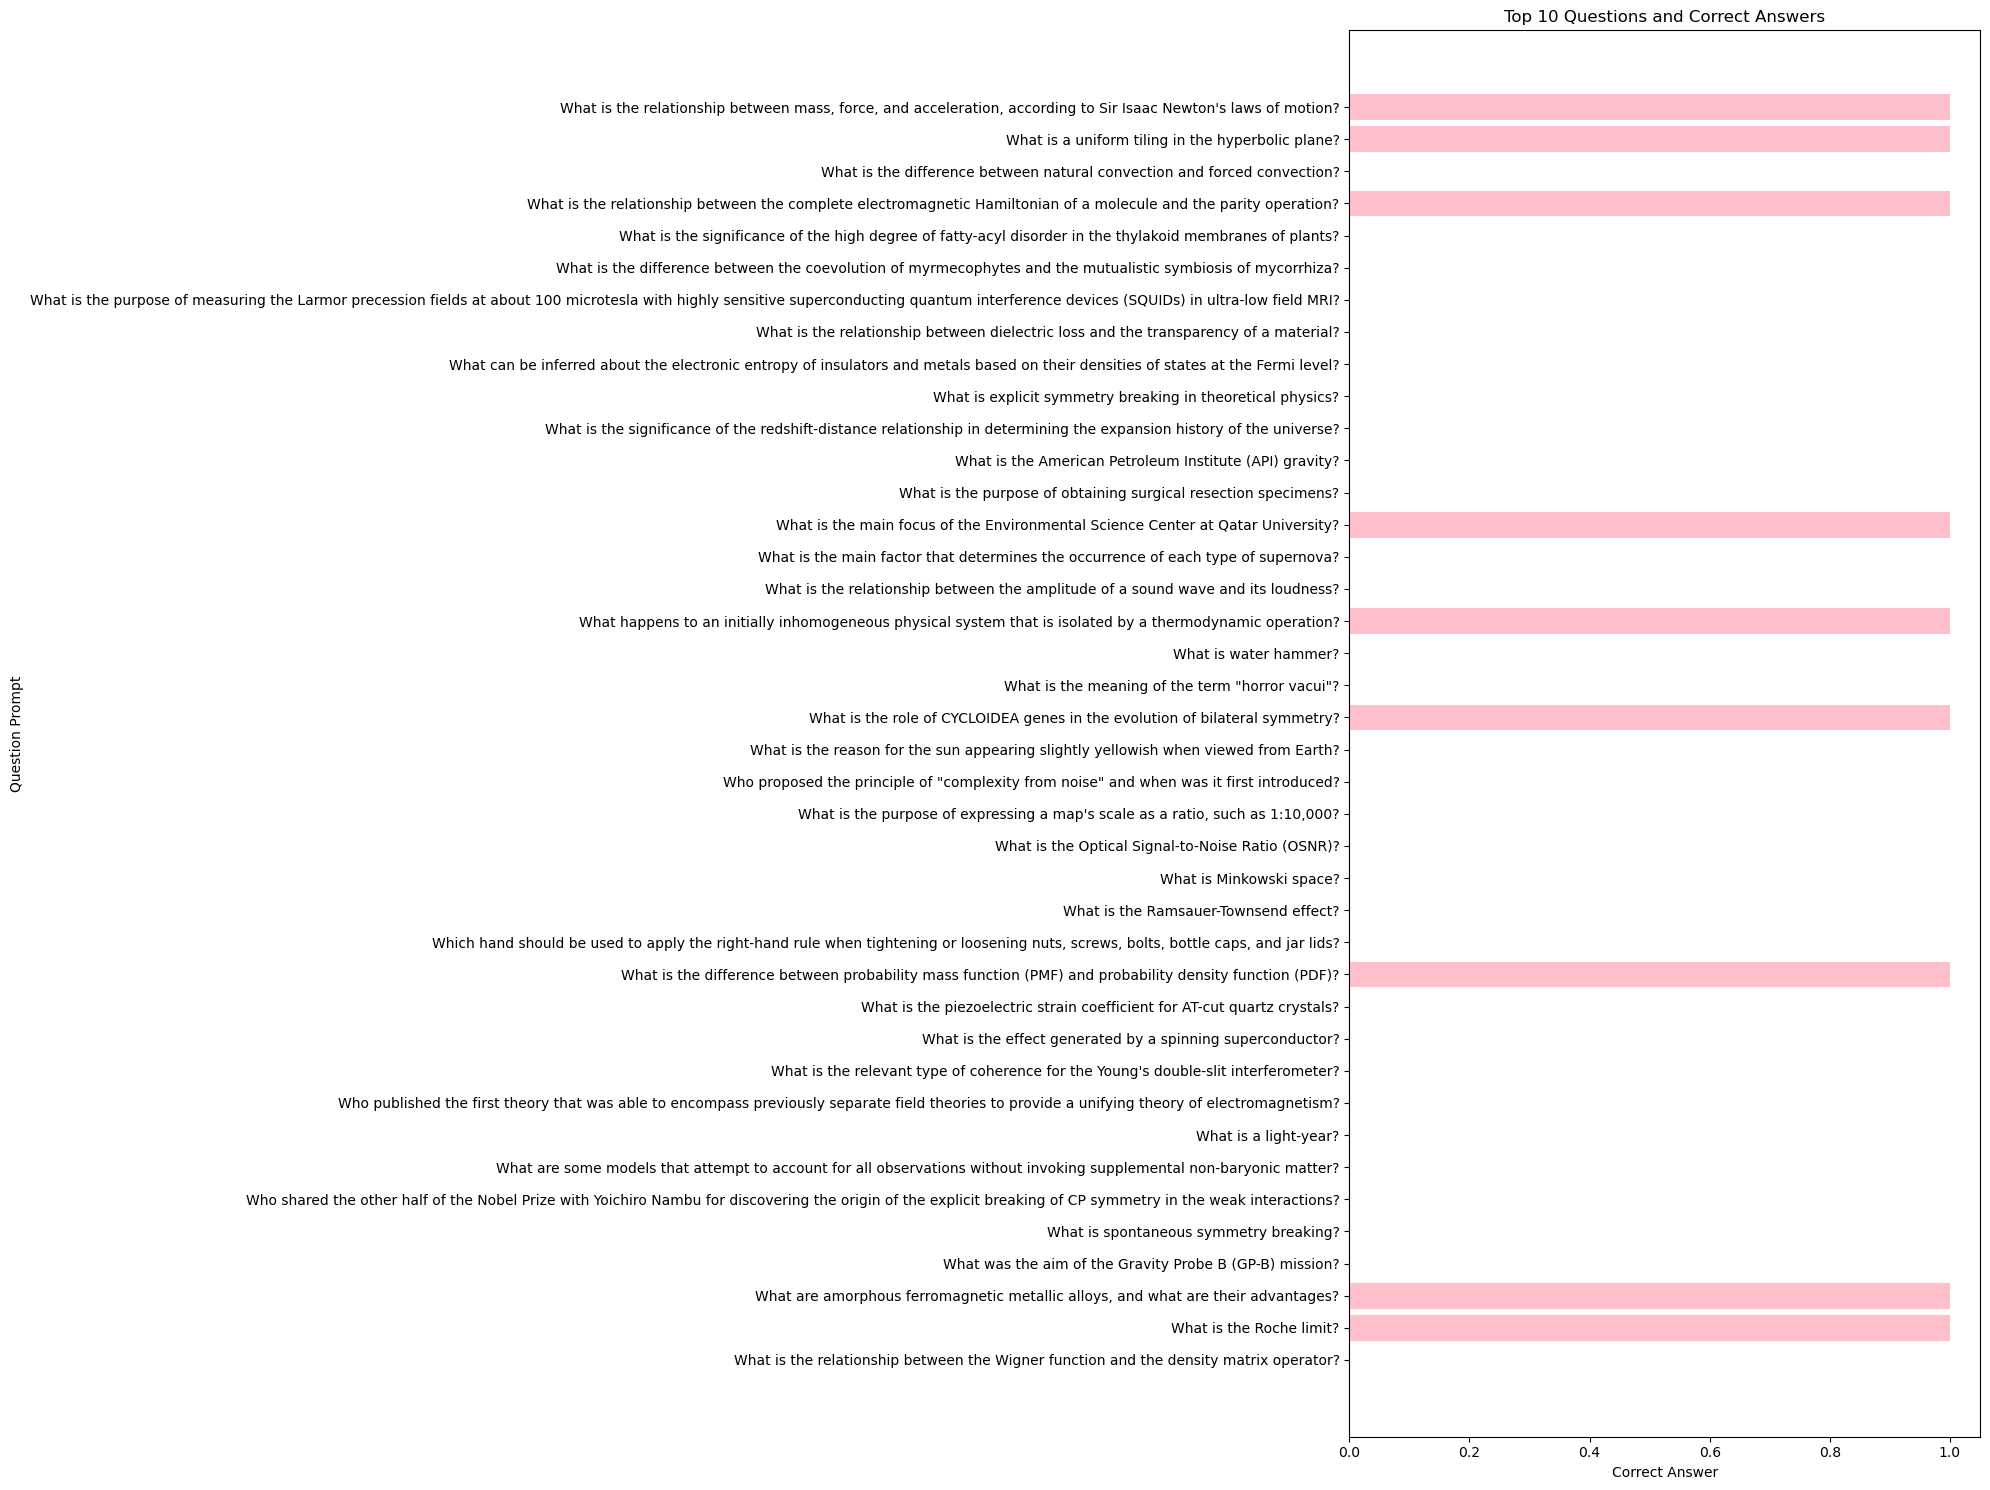

In [11]:
# 获取基于出现次数的前10个提示
top_prompts = final_df["prompt"].value_counts().nlargest(10).index

# 过滤数据框，仅包括前10个提示
df_top_prompts = final_df[final_df["prompt"].isin(top_prompts)]

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(20, 15))

# Set the y-axis labels as the prompt
y = df_top_prompts["prompt"]

# Set the x-axis labels as the correct answer (A, B, C, D, E)
x = df_top_prompts["answer"].map(lambda ans: 1 if ans == "D" else 0)

# Plot the horizontal bar plot
ax.barh(y, x, color=["pink" if ans == "D" else "blue" for ans in df_top_prompts["answer"]])

# Customize the plot
ax.set_yticklabels(y)
ax.set_xlabel("Correct Answer")
ax.set_ylabel("Question Prompt")
ax.set_title("Top 10 Questions and Correct Answers")

plt.tight_layout()
plt.show()

In [1]:
def process_documents(
    documents: Iterable[str],
    document_ids: Iterable,
    split_sentences: bool = True,
    filter_len: int = 9,
    disable_progress_bar: bool = False,
) -> pd.DataFrame:
    """
    主要辅助函数，用于处理来自EMR的文档。

    :param documents: 包含字符串的文档的可迭代对象
    :param document_ids: 包含文档唯一标识符的可迭代对象
    :param split_sentences: 用于确定是否进一步将章节拆分为句子的标志
    :param filter_len: 句子的最小字符长度（否则将被过滤掉）
    :param disable_progress_bar: 禁用tqdm进度条的标志
    :return: 包含列`document_id`、`text`、`section`、`offset`的Pandas DataFrame
    """

    # 调用sectionize_documents函数处理文档并返回数据框
    df = sectionize_documents(documents, document_ids, disable_progress_bar)

    # 如果split_sentences为True，调用sentencize函数拆分句子
    if split_sentences:
        df = sentencize(
            df.text.values,
            df.document_id.values,
            df.offset.values,
            filter_len,
            disable_progress_bar,
        )
    return df

NameError: name 'Iterable' is not defined

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">
    <h3 align="center"><font color='#DAA520'>💡 关于sectionize_documents：</font></h3>
    
    🎭 获取影像报告的章节，并仅返回所选章节（默认为FINDINGS、IMPRESSION和ADDENDUM）
    
    🧨参数 documents：包含字符串文档的可迭代对象

    🥽参数 document_ids：包含文档唯一标识符的可迭代对象
    
    🎍参数 disable_progress_bar：禁用tqdm进度条的标志
    
    🎁返回：包含列`document_id`、`text`、`offset`的Pandas DataFrame
</div>


In [13]:
def sectionize_documents(
    documents: Iterable[str], document_ids: Iterable, disable_progress_bar: bool = False
) -> pd.DataFrame:
    """
    Obtains the sections of the imaging reports and returns only the
    selected sections (defaults to FINDINGS, IMPRESSION, and ADDENDUM).

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `offset`
    """
    processed_documents = []
    for document_id, document in tqdm(zip(document_ids, documents), total=len(documents), disable=disable_progress_bar):
        row = {}
        text, start, end = (document, 0, len(document))
        row["document_id"] = document_id
        row["text"] = text
        row["offset"] = (start, end)

        processed_documents.append(row)

    _df = pd.DataFrame(processed_documents)
    if _df.shape[0] > 0:
        return _df.sort_values(["document_id", "offset"]).reset_index(drop=True)
    else:
        return _df

In [14]:
def sentencize(documents: Iterable[str],
               document_ids: Iterable,
               offsets: Iterable[tuple[int, int]],
               filter_len: int = 9,
               disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Split a document into sentences. Can be used with `sectionize_documents`
    to further split documents into more manageable pieces. Takes in offsets
    to ensure that after splitting, the sentences can be matched to the
    location in the original documents.def sectionize_documents(documents: Iterable[str],
                         document_ids: Iterable,
                         disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    获取影像报告的章节并仅返回所选章节（默认为FINDINGS、IMPRESSION和ADDENDUM）。

    :param documents: 包含字符串文档的可迭代对象
    :param document_ids: 包含文档唯一标识符的可迭代对象
    :param disable_progress_bar: 禁用tqdm进度条的标志
    :return: 包含列`document_id`、`text`、`offset`的Pandas DataFrame
    """
    processed_documents = []
    for document_id, document in tqdm(zip(document_ids, documents), total=len(documents), disable=disable_progress_bar):
        row = {}
        text, start, end = (document, 0, len(document))
        row['document_id'] = document_id
        row['text'] = text
        row['offset'] = (start, end)

        processed_documents.append(row)

    _df = pd.DataFrame(processed_documents)
    if _df.shape[0] > 0:
        return _df.sort_values(['document_id', 'offset']).reset_index(drop=True)
    else:
        return _df


    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param offsets: Iterable tuple of the start and end indices
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """

    document_sentences = []
    for document, document_id, offset in tqdm(zip(documents, document_ids, offsets), total=len(documents), disable=disable_progress_bar):
        try:
            _, sentence_offsets = bf.text_to_sentences_and_offsets(document)
            for o in sentence_offsets:
                if o[1]-o[0] > filter_len:
                    sentence = document[o[0]:o[1]]
                    abs_offsets = (o[0]+offset[0], o[1]+offset[0])
                    row = {}
                    row['document_id'] = document_id
                    row['text'] = sentence
                    row['offset'] = abs_offsets
                    document_sentences.append(row)
        except:
            continue
    return pd.DataFrame(document_sentences)

In [15]:
SIM_MODEL = "/kaggle/input/sentencetransformers-allminilml6v2/sentence-transformers_all-MiniLM-L6-v2"
DEVICE = 0
MAX_LENGTH = 384
BATCH_SIZE = 32
WIKI_PATH = "/kaggle/input/wikipedia-20230701"
wiki_files = os.listdir(WIKI_PATH)

In [16]:
trn = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv").drop("id", 1)
trn.head()

,prompt,A,B,C,D,E
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...


In [17]:
## 合并所有答案
trn["answer_all"] = trn.apply(lambda x: " ".join([x["A"], x["B"], x["C"], x["D"], x["E"]]), axis=1)

## 使用提示和答案来指导搜索
trn["prompt_answer_stem"] = trn["prompt"] + " " + trn["answer_all"]

In [18]:
model = SentenceTransformer(SIM_MODEL, device="cuda")
model.max_seq_length = MAX_LENGTH
model = model.half()

In [19]:
sentence_index = read_index("/kaggle/input/wikipedia-2023-07-faiss-index/wikipedia_202307.index")

In [20]:
prompt_embeddings = model.encode(
    trn.prompt_answer_stem.values,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    show_progress_bar=True,
    convert_to_tensor=True,
    normalize_embeddings=True,
)
prompt_embeddings = prompt_embeddings.detach().cpu().numpy()
_ = gc.collect()

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
search_score, search_index = sentence_index.search(prompt_embeddings, 6)

In [22]:
del sentence_index
del prompt_embeddings
_ = gc.collect()
libc.malloc_trim(0)

1

In [23]:
df = pd.read_parquet("/kaggle/input/wikipedia-20230701/wiki_2023_index.parquet", columns=["id", "file"])

In [24]:
wikipedia_file_data = []

for i, (scr, idx) in tqdm(enumerate(zip(search_score, search_index)), total=len(search_score)):
    scr_idx = idx
    _df = df.loc[scr_idx].copy()
    _df["prompt_id"] = i
    wikipedia_file_data.append(_df)
wikipedia_file_data = pd.concat(wikipedia_file_data).reset_index(drop=True)
wikipedia_file_data = (
    wikipedia_file_data[["id", "prompt_id", "file"]]
    .drop_duplicates()
    .sort_values(["file", "id"])
    .reset_index(drop=True)
)

## Save memory - delete df since it is no longer necessary
del df
_ = gc.collect()
libc.malloc_trim(0)

  0%|          | 0/200 [00:00<?, ?it/s]

1

In [25]:
wiki_text_data = []

for file in tqdm(wikipedia_file_data.file.unique(), total=len(wikipedia_file_data.file.unique())):
    _id = [str(i) for i in wikipedia_file_data[wikipedia_file_data["file"] == file]["id"].tolist()]
    _df = pd.read_parquet(f"{WIKI_PATH}/{file}", columns=["id", "text"])

    _df_temp = _df[_df["id"].isin(_id)].copy()
    del _df
    _ = gc.collect()
    libc.malloc_trim(0)
    wiki_text_data.append(_df_temp)
wiki_text_data = pd.concat(wiki_text_data).drop_duplicates().reset_index(drop=True)
_ = gc.collect()

  0%|          | 0/27 [00:00<?, ?it/s]

In [26]:
processed_wiki_text_data = process_documents(wiki_text_data.text.values, wiki_text_data.id.values)

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

In [27]:
wiki_data_embeddings = model.encode(
    processed_wiki_text_data.text,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    show_progress_bar=True,
    convert_to_tensor=True,
    normalize_embeddings=True,
)  # .half()
wiki_data_embeddings = wiki_data_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/1991 [00:00<?, ?it/s]

In [28]:
_ = gc.collect()

In [29]:
question_embeddings = model.encode(
    trn.prompt_answer_stem.values,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    show_progress_bar=True,
    convert_to_tensor=True,
    normalize_embeddings=True,
)
question_embeddings = question_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
## 参数，确定要包含多少相关句子
NUM_SENTENCES_INCLUDE = 22

## 包含上下文信息的列表
contexts = []

for r in tqdm(trn.itertuples(), total=len(trn)):
    prompt_id = r.Index

    # 获取与提示相关的索引
    prompt_indices = processed_wiki_text_data[
        processed_wiki_text_data["document_id"].isin(
            wikipedia_file_data[wikipedia_file_data["prompt_id"] == prompt_id]["id"].values
        )
    ].index.values

    if prompt_indices.shape[0] > 0:
        # 创建Faiss索引并添加相关文本
        prompt_index = faiss.index_factory(wiki_data_embeddings.shape[1], "Flat")
        prompt_index.add(wiki_data_embeddings[prompt_indices])

        context = ""

        ## 获取前几个匹配项
        ss, ii = prompt_index.search(question_embeddings, NUM_SENTENCES_INCLUDE)
        for _s, _i in zip(ss[prompt_id], ii[prompt_id]):
            context += processed_wiki_text_data.loc[prompt_indices]["text"].iloc[_i] + " "

    contexts.append(context)

  0%|          | 0/200 [00:00<?, ?it/s]

In [31]:
trn["context"] = contexts

In [32]:
trn[["prompt", "context", "A", "B", "C", "D", "E"]].to_csv("./test_context.csv", index=False)

In [33]:
test_df = pd.read_csv("test_context.csv")
test_df.index = list(range(len(test_df)))
test_df["id"] = list(range(len(test_df)))
# 将"prompt"字段的内容与"context"字段的前2300个字符组合，然后添加"####"，再加上"prompt"字段的内容
test_df["prompt"] = test_df["context"].apply(lambda x: x[:2300]) + " #### " + test_df["prompt"]
# 将"answer"字段的值设置为'A'
test_df["answer"] = "A"

In [34]:
model_dir = "/kaggle/input/llm-science-run-context-2"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [35]:
# 我们将创建一个字典，将选项名称（A、B、C、D、E）转换为索引和反向转换
options = "ABCDE"
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}


def preprocess(example):
    # AutoModelForMultipleChoice类需要一组问题/答案对，因此我们将在标记化之前将问题复制5次
    first_sentence = [example["prompt"]] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(example[option])
    # 我们的标记器将把我们的文本转化为BERT可以理解的标记ID
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True)
    tokenized_example["label"] = option_to_index[example["answer"]]
    return tokenized_example

In [36]:
@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        # 确定标签的名称是"label"还是"labels"
        label_name = "label" if "label" in features[0].keys() else "labels"
        # 提取标签并从特征中删除
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        # 重新组织特征以适应批处理处理
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        # 使用标记器进行填充和转换为PyTorch张量
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        # 重新构建批次
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [37]:
tokenized_test_dataset = Dataset.from_pandas(
    test_df[["id", "prompt", "A", "B", "C", "D", "E", "answer"]].drop(columns=["id"])
).map(preprocess, remove_columns=["prompt", "A", "B", "C", "D", "E", "answer"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [38]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

In [39]:
%%time

test_predictions = []
for batch in test_dataloader:
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions.append(outputs.logits.cpu().detach())

test_predictions = torch.cat(test_predictions)
test_predictions = test_predictions.numpy()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


CPU times: user 1min 29s, sys: 77.8 ms, total: 1min 29s
Wall time: 1min 29s


In [40]:
%%time

model_dir = "/kaggle/input/how-to-train-open-book-model-part-1/model_v2/"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

CPU times: user 4.1 s, sys: 1.95 s, total: 6.05 s
Wall time: 24.7 s


DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [41]:
test_predictions2 = []
for batch in test_dataloader:
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions2.append(outputs.logits.cpu().detach())

test_predictions2 = torch.cat(test_predictions2)
test_predictions2 = test_predictions2.numpy()

test_predictions = softmax(test_predictions) + softmax(test_predictions2)

predictions_as_ids = np.argsort(-test_predictions, 1)

predictions_as_answer_letters = np.array(list("ABCDE"))[predictions_as_ids]
# predictions_as_answer_letters[:3]

predictions_as_string = test_df["prediction"] = [" ".join(row) for row in predictions_as_answer_letters[:, :3]]

In [42]:
submission = test_df[["id", "prediction"]]
submission.to_csv("submission.csv", index=False)